In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline
torch.set_num_threads(12)

# Заменить sigmoid+KL на tanh+L1 и проверить работает ли такой подход

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._l1_reg = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_l1 = h
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def L1(self, reg_lambda, size_average=True):
        """
        L1 regularizer
        """
        l1_reg = torch.abs(self.data_l1).sum(0)
        
        if size_average:
            self._l1_reg = l1_reg.mean()
        else:
            self._l1_reg = l1_reg.sum()
        return reg_lambda*self._l1_reg
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
#models = {'16': Net(16), '32': Net(32), '64': Net(64)}
models = {'64': Net(64)}
reg_lambda = 0.001
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            l1_reg = model.L1(reg_lambda)
            loss = model.loss(output, data) + l1_reg
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._l1_reg))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'l1_reg: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.L1(reg_lambda, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.934265
Train Epoch: 1 [10000/50000 (20%)]	Losses 64: 0.273835
Train Epoch: 1 [20000/50000 (40%)]	Losses 64: 0.276542
Train Epoch: 1 [30000/50000 (60%)]	Losses 64: 0.262169
Train Epoch: 1 [40000/50000 (80%)]	Losses 64: 0.253724
Train Epoch: 1 [50000/50000 (100%)]	Losses 64: 0.245857
Test set:
64: loss: 0.2454	l1_reg: 0.0003

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.238242
Train Epoch: 2 [10000/50000 (20%)]	Losses 64: 0.239618
Train Epoch: 2 [20000/50000 (40%)]	Losses 64: 0.223621
Train Epoch: 2 [30000/50000 (60%)]	Losses 64: 0.206554
Train Epoch: 2 [40000/50000 (80%)]	Losses 64: 0.189884
Train Epoch: 2 [50000/50000 (100%)]	Losses 64: 0.162068
Test set:
64: loss: 0.1822	l1_reg: 0.0003

Train Epoch: 3 [0/50000 (0%)]	Losses 64: 0.183235
Train Epoch: 3 [10000/50000 (20%)]	Losses 64: 0.165963
Train Epoch: 3 [20000/50000 (40%)]	Losses 64: 0.165815
Train Epoch: 3 [30000/50000 (60%)]	Losses 64: 0.174681
Train Epoch: 3 [40000/50000 (80%)]	Losses 64: 0

In [9]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded1 = models['64'].decode(torch.eye(64))
decoded2 = models['64'].decode(-torch.eye(64))
dec_to_plot1 = ((decoded1.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
dec_to_plot2 = ((decoded2.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((torch.abs(encoded) > 0.2).sum(1))
    encoded[torch.abs(encoded) < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 18,  21,  13,  21,  17,  15,  17,  17,  21,  17,  23,  16,
         20,  22,  18,  17,  17,  18,  13,  19,  15,  23,  21,  15,
         15,  22,  23,  19,  21,  17,  19,  19,  17,  17,  16,  17,
         20,  16,  14,  11,  20,  16,  18,   9,  18,  16,  17,  19,
         19,  24])


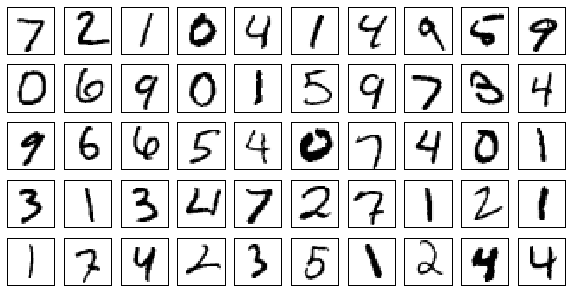

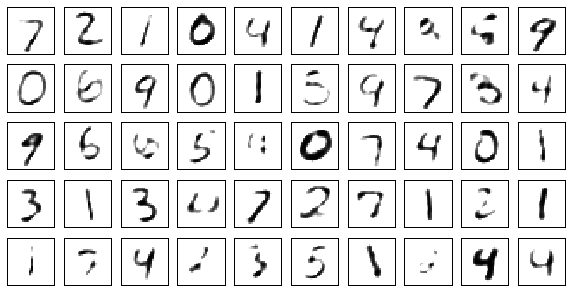

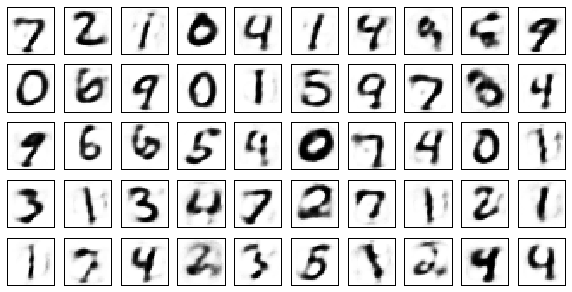

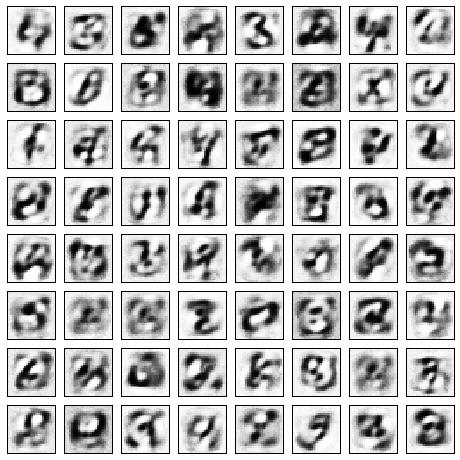

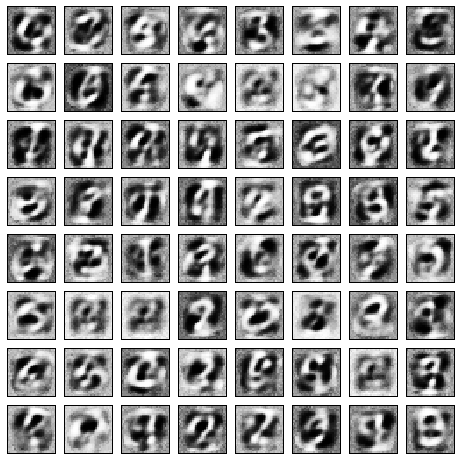

In [10]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot1, (8, 8))
plot_mnist(dec_to_plot2, (8, 8))

activation with tanh works with L1 regularization
